## **Importing Necessary Libraries**

In [33]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from os import listdir
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## **Getting the data from Kaggle**

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download adityajn105/flickr8k

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
! unzip flickr8k.zip

Archive:  flickr8k.zip
replace Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### **Loading The Captions Data**

In [34]:
with open('/content/captions.txt','r') as f:
  next(f)
  caption_corpus = f.read()

In [35]:
caption_corpus.split('\n')[:10]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .']

### **Mapping Images To Captions**

In [36]:
mapping = {}
for line in caption_corpus.split('\n'):
   tokens = line.split(',')
   if len(line) < 2:
     continue
   image_id, captions = tokens[0], tokens[1:]
   image_id = image_id.split('.')[0]
   captions = ' '.join(captions)
   if image_id not in mapping:
     mapping[image_id] = []
   mapping[image_id].append(captions)

In [37]:
len(mapping)

8091

## **Cleaning Captions**

In [38]:
def clean(mapping):
  for image_id, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      caption = caption.lower()
      caption = caption.replace('[^a-z]','')
      caption = caption.replace('\s+',' ')
      caption = ' '.join([word for word in caption.split() if len(word) > 1])
      caption = 'start ' + caption + ' end'
      captions[i] = caption

In [39]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [40]:
clean(mapping)

In [41]:
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

## **Tokenizing The Captions**


In [42]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)
    
len(all_captions)

40455

In [43]:
all_captions[:20]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end',
 'start little girl covered in paint sits in front of painted rainbow with her hands in bowl end',
 'start little girl is sitting in front of large painted rainbow end',
 'start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end',
 'start there is girl with pigtails sitting in fro

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [45]:
vocab_size 

8483

In [46]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## **Extracting Features From Images**

### Loading the model

In [96]:
model = VGG16()

In [97]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Restructuring the model to use it as feature extractor

In [68]:
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Extract features

In [69]:
features = {}
directory = '/content/Images'
for img_name in tqdm(listdir(directory)):
  img_path = directory + '/' + img_name
  image = load_img(img_path, target_size = (224,224))
  image = img_to_array(image)
  image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
  image = preprocess_input(image)
  feature = model.predict(image)
  img_id = img_name.split('.')[0]
  features[img_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

### **Pickle Features**

In [79]:
dir = open('Vgg16_features.pkl','wb')
pickle.dump(features,dir)

In [47]:
with open('features.pkl','rb') as f:
  features = pickle.load(f)

## **Train Test Split**

In [48]:
image_id = list(mapping.keys())
split_size = int(len(image_id) * 0.90)
split_size

7281

In [49]:
train = image_id[:split_size]
test = image_id[split_size:]
len(train), len(test)

(7281, 810)

### **Preprocessing Input**

In [50]:
def data_generator(image_id,mapping,features,tokenizer,max_length,vocab_size,batch_size):
  X1, X2, y = list(),list(),list()
  n = 0
  while 1:
    for id in image_id:
      n += 1
      captions = mapping[id]
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1,len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
          out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]

          X1.append(features[id][0])
          X2.append(in_seq)
          y.append(out_seq)

      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1,X2], y
        X1, X2, y = list(),list(),list()
        n = 0



## **Model Building**

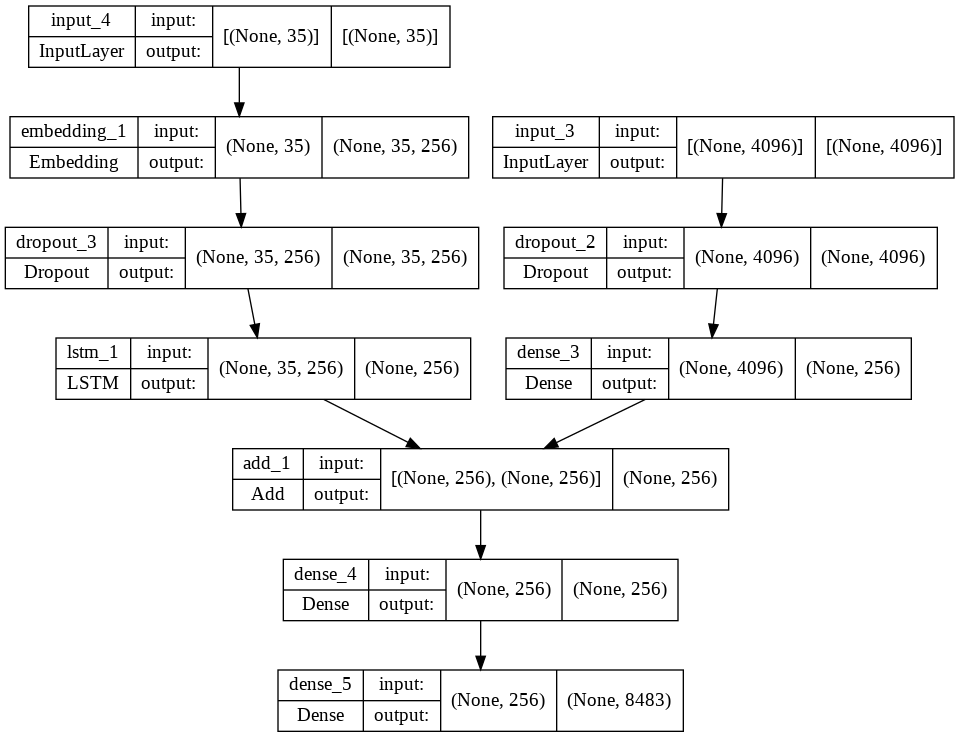

In [51]:
# Encoder
image_input = Input(shape = (4096,))
h_layer_1 = Dropout(0.4)(image_input)
image_output = Dense(256,activation='relu')(h_layer_1)

text_input = Input(shape = (max_length,))
h_layer_2 = Embedding(vocab_size,256,mask_zero = True)(text_input)
h_layer_3 = Dropout(0.4)(h_layer_2)
text_output = LSTM(256)(h_layer_3)

#Decoder
decoder_1 = add([image_output, text_output])
decoder_2 = Dense(256,activation = 'relu')(decoder_1)
output = Dense(vocab_size,activation = 'softmax')(decoder_2)

#Compilation
model = Model(inputs = [image_input, text_input], outputs = output)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

#Plotting
plot_model(model,show_shapes='True')

## **Training the Model**

In [52]:
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
  generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)

  model.fit(generator,epochs = 1,steps_per_epoch = steps,verbose = 1)

227/227 [==============================] - 56s 248ms/step - loss: 1.7195


In [28]:
model.save('captioning_model.h5')

## **Generating Captions From Image**

In [54]:
def id_to_word(x,tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == x:
      return word
  return None

In [55]:
def predict_captions(model,image,tokenizer,max_length):
  in_text = 'start'
  for i in range(max_length):
    seq = tokenizer.texts_to_sequences([in_text])[0]
    seq = pad_sequences([seq],maxlen = max_length)
    y_pred = model.predict([image,seq])
    y_pred = np.argmax(y_pred)
    word = id_to_word(y_pred,tokenizer)
    if word is None:
      break
    in_text += " " + word
    if word == 'end':
      break
  return in_text


In [46]:
y_test,y_pred = list(),list()

for key in tqdm(test):
  captions = mapping[key]
  predictions = predict_captions(model, features[key], tokenizer, max_length)
  actual = [caption.split() for caption in captions]
  predictions = predictions.split()

  y_test.append(actual)
  y_pred.append(predictions)

print(f'BLEU Score Unigram = {corpus_bleu(y_test, y_pred, weights = (1.0, 0, 0, 0))}')
print(f'BLEU Score Bigram = {corpus_bleu(y_test, y_pred, weights = (0.5, 0.5, 0, 0))}')



  0%|          | 0/810 [00:00<?, ?it/s]

BLEU Score Unigram = 0.5269728042799822
BLEU Score Bigram = 0.3003267451165281


## **Visualise The Results**

In [69]:
def show_preds(img_name): 
  image_id = img_name.split('.')[0]
  img_path = '/content/Images/' + img_name
  image = Image.open(img_path)
  caption = mapping[image_id]

  print('-------------------Actual-------------------')
  for x in caption:
    print(x)


  print('-------------------Predicted-------------------')
  print(predict_captions(model,features[image_id], tokenizer, max_length))
  plt.imshow(image)

-------------------Actual-------------------
start guy with nose piercing end
start man in red cap with nose ring end
start teenage boy has silver ring protruding from his nose end
start closeup picture of man with nose ring and brown shirt end
start young man with nose ring and hat end
-------------------Predicted-------------------
start closeup of man with nose ring and nose end


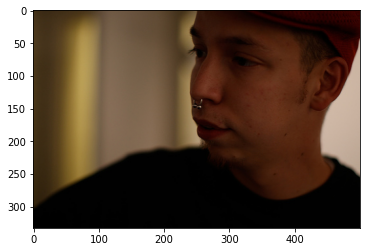

In [73]:
show_preds('1167662968_e466f1e80a.jpg')

-------------------Actual-------------------
start child is standing on her head end
start little girl standing on her head end
start small child doing handstand on bed end
start young girl does handstand on bed with blue sheets end
start the girl is upside down on bed end
-------------------Predicted-------------------
start little girl in shorts is doing handstand on bed end


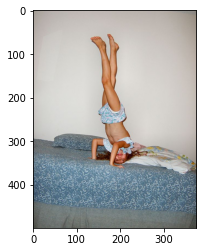

In [72]:
show_preds('1121416483_c7902d0d49.jpg')